In [111]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import _pickle as pickle
import xgboost as xgb
import lightgbm as lgb
from sklearn import preprocessing, metrics
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, GridSearchCV, RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from datetime import timedelta, date
from dateutil import relativedelta
from sklearn import preprocessing
from sklearn.cluster import KMeans

%matplotlib inline

In [112]:
data_hero=pd.read_csv('C:/MyData/hub_project/AVHack/Felicity/Input/hero_data.csv')
data_hero.columns

Index(['hero_id', 'primary_attr', 'attack_type', 'roles', 'base_health',
       'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
       'base_magic_resistance', 'base_attack_min', 'base_attack_max',
       'base_strength', 'base_agility', 'base_intelligence', 'strength_gain',
       'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate'],
      dtype='object')

In [113]:
mat=np.zeros(shape=(data_hero.shape[0],len(list(np.unique(np.array(':'.join(list(data_hero.roles)).split(':')))))))
df_ft=pd.DataFrame(mat)
df_ft.columns = list(np.unique(np.array(':'.join(list(data_hero.roles)).split(':'))))

for element in df_ft.columns:
    df_ft[element] = pd.np.where(data_hero.roles.str.contains(element),1,0)

In [114]:
data_hero_processed = pd.concat([data_hero,df_ft],axis=1)
data_hero_processed.columns

Index(['hero_id', 'primary_attr', 'attack_type', 'roles', 'base_health',
       'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
       'base_magic_resistance', 'base_attack_min', 'base_attack_max',
       'base_strength', 'base_agility', 'base_intelligence', 'strength_gain',
       'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate', 'Carry', 'Disabler',
       'Durable', 'Escape', 'Initiator', 'Jungler', 'Nuker', 'Pusher',
       'Support'],
      dtype='object')

In [115]:
for c in ['primary_attr', 'attack_type']:
    lbl = preprocessing.LabelEncoder()
    lbl.fit(list(data_hero_processed[c].values.astype('str')))
    data_hero_processed[c] = lbl.transform(list(data_hero_processed[c].values.astype('str')))
data_hero_processed.drop(['roles'],axis=1,inplace=True)
data_hero_processed.columns

Index(['hero_id', 'primary_attr', 'attack_type', 'base_health',
       'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
       'base_magic_resistance', 'base_attack_min', 'base_attack_max',
       'base_strength', 'base_agility', 'base_intelligence', 'strength_gain',
       'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate', 'Carry', 'Disabler',
       'Durable', 'Escape', 'Initiator', 'Jungler', 'Nuker', 'Pusher',
       'Support'],
      dtype='object')

In [116]:
data_hero_processed.shape[0] == data_hero.shape[0]

True

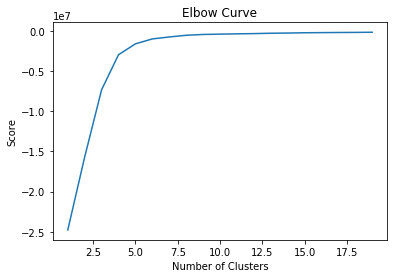

In [117]:
all_possible_cluster = range(1, 20,1)
kmeans = [KMeans(n_clusters=i) for i in all_possible_cluster]
score = [kmeans[i].fit(data_hero_processed).score(data_hero_processed) for i in range(len(kmeans))]

plt.plot(all_possible_cluster,score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

In [118]:
kmeans_model=KMeans(n_clusters=4)
kmeans_model.fit(data_hero_processed)
kmeans_model.labels_

array([3, 1, 0, 1, 0, 0, 3, 3, 0, 0, 0, 1, 0, 3, 2, 1, 0, 3, 1, 0, 0, 0, 1,
       0, 0, 0, 3, 1, 0, 0, 1, 0, 0, 2, 0, 0, 3, 0, 0, 1, 3, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1,
       1, 2, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 3,
       0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1])

In [119]:
data_hero_processed['cluster_for_hero']=kmeans_model.labels_

In [120]:
data_hero_processed.columns

Index(['hero_id', 'primary_attr', 'attack_type', 'base_health',
       'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
       'base_magic_resistance', 'base_attack_min', 'base_attack_max',
       'base_strength', 'base_agility', 'base_intelligence', 'strength_gain',
       'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate', 'Carry', 'Disabler',
       'Durable', 'Escape', 'Initiator', 'Jungler', 'Nuker', 'Pusher',
       'Support', 'cluster_for_hero'],
      dtype='object')

In [121]:
data_hero_processed.to_csv('intermediate/hero_processed.csv',header=True,sep=',')

In [122]:
data_train_1=pd.read_csv('C:/MyData/hub_project/AVHack/Felicity/Input/train1.csv')
data_train_9=pd.read_csv('C:/MyData/hub_project/AVHack/Felicity/Input/train9.csv')
data_test_1=pd.read_csv('C:/MyData/hub_project/AVHack/Felicity/Input/test1.csv')
data_test_9=pd.read_csv('C:/MyData/hub_project/AVHack/Felicity/Input/test9.csv')

In [123]:
print(data_train_1.shape,data_train_9.shape)
print(data_test_1.shape,data_test_9.shape)
data_test_1['kda_ratio']=-99
data_test_1['num_wins']=-99
print(data_train_1.shape,data_train_9.shape)
print(data_test_1.shape,data_test_9.shape)

(2094, 6) (18846, 6)
(898, 4) (8082, 6)
(2094, 6) (18846, 6)
(898, 6) (8082, 6)


In [124]:
data_train_1['type']='data_train_1'
data_train_9['type']='data_train_9'
data_test_1['type']='data_test_1'
data_test_9['type']='data_test_9'
print(data_train_1.shape,data_train_9.shape)
print(data_test_1.shape,data_test_9.shape)

(2094, 7) (18846, 7)
(898, 7) (8082, 7)


In [125]:
all_data_train=pd.concat([data_test_9,data_train_9])
all_data_test=pd.concat([data_test_1,data_train_1])

print(all_data_train.type.value_counts())
print(all_data_test.type.value_counts())

data_train_9    18846
data_test_9      8082
Name: type, dtype: int64
data_train_1    2094
data_test_1      898
Name: type, dtype: int64


In [126]:
all_data_train['Wining_chance']=(all_data_train.num_wins/all_data_train.num_games)*100
all_data_train['Wining_chance']=all_data_train['Wining_chance'].astype(int)

In [127]:
all_data_train_with_feature=pd.merge(all_data_train, data_hero_processed, how='left', on='hero_id')

In [128]:
all_data_train_with_feature.columns

Index(['user_id', 'hero_id', 'id', 'num_games', 'num_wins', 'kda_ratio',
       'type', 'Wining_chance', 'primary_attr', 'attack_type', 'base_health',
       'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
       'base_magic_resistance', 'base_attack_min', 'base_attack_max',
       'base_strength', 'base_agility', 'base_intelligence', 'strength_gain',
       'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate', 'Carry', 'Disabler',
       'Durable', 'Escape', 'Initiator', 'Jungler', 'Nuker', 'Pusher',
       'Support', 'cluster_for_hero'],
      dtype='object')

In [129]:
all_data_train_with_feature.to_csv('all_data_train_with_feature.csv',header=True,sep=',')

In [130]:
'''f = {'num_games': ['mean','std'],'kda_ratio': ['mean','std'],'Wining_chance': ['mean']}
all_data_train_with_feature_cluster=all_data_train_with_feature.groupby(['cluster_for_hero'], as_index=False).agg(f)
all_data_train_with_feature_cluster.columns = ['cluster_for_hero','kda_ratio_mean_cluster','kda_ratio_std_cluster','num_games_mean_cluster', 'num_games_std_cluster', 'Wining_chance_mean_cluster']'''

"f = {'num_games': ['mean','std'],'kda_ratio': ['mean','std'],'Wining_chance': ['mean']}\nall_data_train_with_feature_cluster=all_data_train_with_feature.groupby(['cluster_for_hero'], as_index=False).agg(f)\nall_data_train_with_feature_cluster.columns = ['cluster_for_hero','kda_ratio_mean_cluster','kda_ratio_std_cluster','num_games_mean_cluster', 'num_games_std_cluster', 'Wining_chance_mean_cluster']"

In [131]:
f = {'num_games': ['mean','std','max','min','count'],'kda_ratio': ['mean','std','max','min','count'],'Wining_chance': ['mean']}
all_data_train_with_feature_cluster=all_data_train_with_feature.groupby(['cluster_for_hero'], as_index=False).agg(f)
all_data_train_with_feature_cluster.columns = ['cluster_for_hero','kda_ratio_mean_cluster','kda_ratio_std_cluster','kda_ratio_max_cluster','kda_ratio_min_cluster','kda_ratio_count_cluster','num_games_mean_cluster', 'num_games_std_cluster', 'num_games_max_cluster','num_games_min_cluster','num_games_count_cluster','Wining_chance_mean_cluster']

In [132]:
all_data_train_with_feature_cluster.to_csv('intermediate/all_data_train_with_feature_cluster.csv',header=True,sep=',')

In [133]:
'''f = {'num_games': ['mean','std'],'kda_ratio': ['mean','std'],'Wining_chance': ['mean']}
all_data_train_with_feature_user=all_data_train_with_feature.groupby(['user_id','cluster_for_hero'], as_index=False).agg(f)
all_data_train_with_feature_user.columns = ['user_id','cluster_for_hero','kda_ratio_mean_user','kda_ratio_std_user','num_games_mean_user', 'num_games_std_user','Wining_chance_mean_user']'''

"f = {'num_games': ['mean','std'],'kda_ratio': ['mean','std'],'Wining_chance': ['mean']}\nall_data_train_with_feature_user=all_data_train_with_feature.groupby(['user_id','cluster_for_hero'], as_index=False).agg(f)\nall_data_train_with_feature_user.columns = ['user_id','cluster_for_hero','kda_ratio_mean_user','kda_ratio_std_user','num_games_mean_user', 'num_games_std_user','Wining_chance_mean_user']"

In [134]:
f = {'num_games': ['mean','std','max','min','count'],'kda_ratio': ['mean','std','max','min','count'],'Wining_chance': ['mean']}
all_data_train_with_feature_user=all_data_train_with_feature.groupby(['user_id','cluster_for_hero'], as_index=False).agg(f)
all_data_train_with_feature_user.columns = ['user_id','cluster_for_hero','kda_ratio_mean_user','kda_ratio_std_user','kda_ratio_max_user','kda_ratio_min_user','kda_ratio_count_user','num_games_mean_user', 'num_games_std_user', 'num_games_max_user','num_games_min_user','num_games_count_user','Wining_chance_mean_user']

In [135]:
all_data_train_with_feature_user.to_csv('intermediate/all_data_train_with_feature_user.csv',header=True,sep=',')

In [136]:
all_data_test_with_feature=pd.merge(all_data_test, data_hero_processed, how='left', on='hero_id')

In [137]:
all_data_test_with_feature.columns

Index(['hero_id', 'id', 'kda_ratio', 'num_games', 'num_wins', 'type',
       'user_id', 'primary_attr', 'attack_type', 'base_health',
       'base_health_regen', 'base_mana', 'base_mana_regen', 'base_armor',
       'base_magic_resistance', 'base_attack_min', 'base_attack_max',
       'base_strength', 'base_agility', 'base_intelligence', 'strength_gain',
       'agility_gain', 'intelligence_gain', 'attack_range', 'projectile_speed',
       'attack_rate', 'move_speed', 'turn_rate', 'Carry', 'Disabler',
       'Durable', 'Escape', 'Initiator', 'Jungler', 'Nuker', 'Pusher',
       'Support', 'cluster_for_hero'],
      dtype='object')

In [138]:
all_data_test_with_feature_cluster=pd.merge(all_data_test_with_feature, all_data_train_with_feature_cluster, how='left', on='cluster_for_hero')

In [139]:
all_data_test_with_feature_cluster_user=pd.merge(all_data_test_with_feature_cluster, all_data_train_with_feature_user, how='left', on=['user_id','cluster_for_hero'])

In [140]:
all_data_test_with_feature_cluster_user.to_csv('intermediate/all_data_test_with_feature_cluster_user.csv',header=True,sep=',')

In [141]:
all_data_test_with_feature_cluster_user.fillna(0,inplace=True)

In [142]:
column_to_drop = ['hero_id','id','user_id','type','num_wins']
response = ['kda_ratio']

In [143]:
train = all_data_test_with_feature_cluster_user.loc[all_data_test_with_feature_cluster_user['type']=='data_train_1',:]
test = all_data_test_with_feature_cluster_user.loc[all_data_test_with_feature_cluster_user['type']=='data_test_1',:]

In [144]:
train.reset_index(drop=True,inplace=True)
test.reset_index(drop=True,inplace=True)

In [145]:
print(train.shape[0]==data_train_1.shape[0])
print(test.shape[0]==data_test_1.shape[0])

True
True


In [183]:
train_X = train.drop(column_to_drop+response, axis=1)
train_y = (train['kda_ratio']).values
test_X = test.drop(column_to_drop+response, axis=1)

In [147]:
'''train_X_1 = train.drop(column_to_drop+response, axis=1)
train_y_1 = train['kda_ratio']
test_X_1 = test.drop(column_to_drop+response, axis=1)

scaler = preprocessing.MinMaxScaler()
scaler.fit(train_X_1)
scaled_train_X=scaler.transform(train_X_1)
scaled_test_X=scaler.transform(test_X_1)

train_X = pd.DataFrame(scaled_train_X, columns=train_X_1.columns)
test_X = pd.DataFrame(scaled_test_X, columns=test_X_1.columns)
train_y = train_y_1'''

"train_X_1 = train.drop(column_to_drop+response, axis=1)\ntrain_y_1 = train['kda_ratio']\ntest_X_1 = test.drop(column_to_drop+response, axis=1)\n\nscaler = preprocessing.MinMaxScaler()\nscaler.fit(train_X_1)\nscaled_train_X=scaler.transform(train_X_1)\nscaled_test_X=scaler.transform(test_X_1)\n\ntrain_X = pd.DataFrame(scaled_train_X, columns=train_X_1.columns)\ntest_X = pd.DataFrame(scaled_test_X, columns=test_X_1.columns)\ntrain_y = train_y_1"

In [148]:
train.to_csv('intermediate/train.csv',header=True,sep=',')
test.to_csv('intermediate/test.csv',header=True,sep=',')

In [149]:
train_X.to_csv('intermediate/train_X.csv',header=True,sep=',')
train_y.to_csv('intermediate/train_y.csv',header=True,sep=',')
test_X.to_csv('intermediate/test_X.csv',header=True,sep=',')

## Light GBM

In [54]:
def runLGB(dev_X, dev_y, val_X, val_y, test_X = None, params = None, rounds = 5000, variableImportance = False):
    if params is None:
        params = {'task': 'train',
                  'boosting_type':'gbdt', 
                  'num_leaves':31, 
                  'max_depth':-1,
                  'learning_rate':0.1,
                  'objective':'regression',
                  'class_weight':None,
                  'min_split_gain':0.0, 
                  'min_child_weight':0.001,
                  'min_child_samples':20, 
                  'subsample':1.0, 
                  'subsample_freq':1, 
                  'colsample_bytree':1.0,
                  'reg_alpha':0.0, 
                  'reg_lambda':0.0, 
                  'random_state':2018,
                  'n_jobs':-1, 
                  'silent':True,
                  'metric': 'rmse'}
        
    num_rounds = rounds

    plst = list(params.items())
    lgb_dev = lgb.Dataset(dev_X, label=dev_y)
    if val_y is not None:
        lgb_val = lgb.Dataset(val_X, label=val_y)
        model = lgb.train(params,lgb_dev,num_boost_round=num_rounds,valid_names=['dev','val'],valid_sets=[lgb_dev,lgb_val],early_stopping_rounds=100,verbose_eval=100)
    else:
        model = lgb.train(params, lgb_dev, num_rounds)
    
    if variableImportance:
        print('Variable Importance Plot')
        lgb.plot_importance(model)
        plt.figure(figsize=(15,15))
        plt.show()
    
    pred_val_y = model.predict(val_X, num_iteration=model.best_iteration)
    
    if test_X is not None:
        pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    else: 
        pred_test_y = np.nan
    
    score = 0
    if val_y is not None:
        score =  metrics.mean_squared_error(val_y, pred_val_y)
        return pred_val_y, score, pred_test_y
    else:
        return pred_val_y, score, pred_test_y

c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\lightgbm\basic.py:644: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	dev's rmse: 402.51	val's rmse: 675.854
Early stopping, best iteration is:
[39]	dev's rmse: 535.984	val's rmse: 653.257
Variable Importance Plot


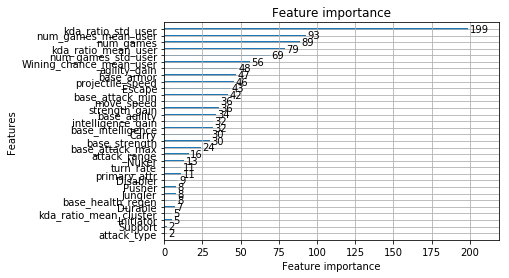

Score:426745.2046190965


In [56]:
dev_X, val_X, dev_y, val_y = train_test_split(train_X,train_y,test_size = 0.2, random_state = 2018)
pred_val_y, score, pred_test_y = runLGB(dev_X, dev_y, val_X, val_y, rounds=10000, variableImportance=True)
print('Score:{}'.format(score))

In [93]:
params = {'boosting_type':'gbdt', 
          'num_leaves':31, 
          'max_depth':-1,
          'learning_rate':0.1, 
          'n_estimators':100, 
          'subsample_for_bin':200000, 
          'objective':'regression',
          'class_weight':None,
          'min_split_gain':0.0, 
          'min_child_samples':20, 
          'subsample':1.0, 
          'subsample_freq':1, 
          'colsample_bytree':1.0,
          'reg_alpha':0.0, 
          'reg_lambda':0.0, 
          'random_state':2018,
          'n_jobs':-1, 
          'silent':True,
          'metric': 'rmse'}

def return_lgb_model():
    lgb_model = lgb.LGBMRegressor(boosting_type= params['boosting_type'],num_leaves = params['num_leaves'],
                                max_depth = params['max_depth'],learning_rate =  params['learning_rate'],
                                n_estimators = params['n_estimators'],subsample_for_bin = params['subsample_for_bin'],
                                objective = params['objective'],min_split_gain = params['min_split_gain'],
                                min_child_samples = params['min_child_samples'],
                                subsample = params['subsample'],subsample_freq = params['subsample_freq'],
                                colsample_bytree = params['colsample_bytree'],reg_alpha = params['reg_alpha'],
                                reg_lambda = params['reg_lambda'],random_state = params['random_state'],
                                n_jobs = params['n_jobs'],silent = params['silent'])
    return lgb_model

In [61]:
params['n_estimators']=39

In [62]:
lgb_rgsr = return_lgb_model()

param_test_num_leaves = {
 'num_leaves': range(2,4,1)
}
gsearch_param_test_num_leaves = GridSearchCV(lgb_rgsr, param_grid = param_test_num_leaves, scoring='mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch_param_test_num_leaves.fit(train_X,train_y)
print(gsearch_param_test_num_leaves.grid_scores_)
print("Best parameter: {}, score: {}".format(gsearch_param_test_num_leaves.best_params_['num_leaves'], gsearch_param_test_num_leaves.best_score_))

[mean: -619598.26746, std: 176665.05302, params: {'num_leaves': 2}, mean: -559337.23069, std: 168598.71285, params: {'num_leaves': 3}]
Best parameter: 3, score: -559337.2306866955


c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [63]:
params['num_leaves']=gsearch_param_test_num_leaves.best_params_['num_leaves']

In [70]:
params['num_leaves']

3

In [65]:
lgb_rgsr = return_lgb_model()

param_test_min_data_in_leaf = {
 'min_data_in_leaf': [12,13,14]
}
gsearch_param_test_min_data_in_leaf = GridSearchCV(lgb_rgsr, param_grid = param_test_min_data_in_leaf, scoring='mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch_param_test_min_data_in_leaf.fit(train_X,train_y)
print(gsearch_param_test_min_data_in_leaf.grid_scores_)
print("Best parameter: {}, score: {}".format(gsearch_param_test_min_data_in_leaf.best_params_['min_data_in_leaf'], gsearch_param_test_min_data_in_leaf.best_score_))

[mean: -559449.77464, std: 169240.29238, params: {'min_data_in_leaf': 12}, mean: -559936.09666, std: 168033.68125, params: {'min_data_in_leaf': 13}, mean: -559995.21734, std: 167976.42189, params: {'min_data_in_leaf': 14}]
Best parameter: 12, score: -559449.7746375547


c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [66]:
params['min_data_in_leaf']=gsearch_param_test_min_data_in_leaf.best_params_['min_data_in_leaf']

In [71]:
params['min_data_in_leaf']

12

In [67]:
lgb_rgsr = return_lgb_model()

param_test_max_depth = {
 'max_depth':[1,2,3,4]
}
gsearch_max_depth = GridSearchCV(lgb_rgsr, param_grid = param_test_max_depth, scoring='mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch_max_depth.fit(train_X,train_y)
print(gsearch_max_depth.grid_scores_)
print("Best parameter: {}, score: {}".format(gsearch_max_depth.best_params_['max_depth'], gsearch_max_depth.best_score_))

[mean: -619598.26746, std: 176665.05302, params: {'max_depth': 1}, mean: -559337.23069, std: 168598.71285, params: {'max_depth': 2}, mean: -559337.23069, std: 168598.71285, params: {'max_depth': 3}, mean: -559337.23069, std: 168598.71285, params: {'max_depth': 4}]
Best parameter: 2, score: -559337.2306866955


c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [68]:
params['max_depth'] = gsearch_max_depth.best_params_['max_depth']

In [69]:
params['max_depth']

2

In [ ]:
lgb_rgsr = return_lgb_model()

param_test_max_bin = {
 'max_bin':[1,5,10,20]
}
gsearch_max_bin = GridSearchCV(lgb_rgsr, param_grid = param_test_max_bin, scoring='mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch_max_bin.fit(train_X,train_y)
print(gsearch_max_bin.grid_scores_)
print("Best parameter: {}, score: {}".format(gsearch_max_bin.best_params_['max_depth'], gsearch_max_bin.best_score_))

In [ ]:
params['max_bin'] = gsearch_max_depth.best_params_['max_bin']

In [ ]:
'''lgb_rgsr = return_lgb_model()

param_test_min_child_weight = {
 'min_child_weight':range(10,17,1),
}
gsearch_param_test_min_child_weight = GridSearchCV(lgb_rgsr, param_grid = param_test_min_child_weight, scoring='mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch_param_test_min_child_weight.fit(train_X,train_y)
print(gsearch_param_test_min_child_weight.grid_scores_)
print("Best parameter: {}, score: {}".format(gsearch_param_test_min_child_weight.best_params_['min_child_weight'], gsearch_param_test_min_child_weight.best_score_))
params['min_child_weight']=gsearch_param_test_min_child_weight.best_params_['min_child_weight']'''

In [78]:
lgb_rgsr = return_lgb_model()

param_test_sample= {
 'subsample': [0.73],
 'colsample_bytree': [0.85,0.86,0.87]
}
gsearch_param_test_sample = GridSearchCV(lgb_rgsr, param_grid = param_test_sample, scoring='mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch_param_test_sample.fit(train_X,train_y)
print(gsearch_param_test_sample.grid_scores_)
print("Best subsample: {}, colsample_bytree: {}, score: {}".format(gsearch_param_test_sample.best_params_['subsample'],gsearch_param_test_sample.best_params_['colsample_bytree'], gsearch_param_test_sample.best_score_))

[mean: -561288.39092, std: 166841.85201, params: {'colsample_bytree': 0.85, 'subsample': 0.73}, mean: -561288.39092, std: 166841.85201, params: {'colsample_bytree': 0.86, 'subsample': 0.73}, mean: -563057.34055, std: 166023.02970, params: {'colsample_bytree': 0.87, 'subsample': 0.73}]
Best subsample: 0.73, colsample_bytree: 0.85, score: -561288.3909247871


c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [79]:
params['subsample']=gsearch_param_test_sample.best_params_['subsample']
params['colsample_bytree']=gsearch_param_test_sample.best_params_['colsample_bytree']

In [90]:
params['subsample'],params['colsample_bytree']

(0.73, 0.85)

In [87]:
lgbclf = return_lgb_model()
param_test_regularizer = {
    'reg_alpha' : [0.001],
    'reg_lambda' : [0.01,0.02,0.04,0.03]
}
gsearch_regularizer = GridSearchCV(lgbclf, param_grid = param_test_regularizer, scoring='mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch_regularizer.fit(train_X,train_y)
print(gsearch_regularizer.grid_scores_ )
print("Best reg_alpha: {}, reg_lambda: {}, score: {}".format(gsearch_regularizer.best_params_['reg_alpha'],gsearch_regularizer.best_params_['reg_lambda'], gsearch_regularizer.best_score_))

[mean: -561293.62825, std: 166842.47476, params: {'reg_alpha': 0.001, 'reg_lambda': 0.01}, mean: -561081.88325, std: 166740.87742, params: {'reg_alpha': 0.001, 'reg_lambda': 0.02}, mean: -561092.41697, std: 166742.14829, params: {'reg_alpha': 0.001, 'reg_lambda': 0.04}, mean: -561087.15025, std: 166741.51257, params: {'reg_alpha': 0.001, 'reg_lambda': 0.03}]
Best reg_alpha: 0.001, reg_lambda: 0.02, score: -561081.8832473827


c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [88]:
params['reg_alpha']=gsearch_regularizer.best_params_['reg_alpha']
params['reg_lambda']=gsearch_regularizer.best_params_['reg_lambda']

In [89]:
params['reg_alpha'],params['reg_lambda']

(0.001, 0.02)

In [96]:
params['learning_rate'] = 0.005

In [97]:
params['learning_rate']

0.005

In [98]:
model_names = ['LGB']
print("Model building..")
kf = KFold(n_splits=5, shuffle=True, random_state=2018)
cv_scores = []
pred_test_full = 0
pred_val_full = np.zeros(train_X.shape[0])
for model_name in model_names:
    print("Running model: {}".format(model_name))
    for dev_index, val_index in kf.split(train_X):
        print(len(dev_index), len(val_index))
        dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        if model_name == "XGB":
            pred_val_y, score, pred_test_y = runXGB(dev_X, dev_y, val_X, val_y, rounds=7000)
        elif model_name == "LGB":
            pred_val_y, score, pred_test_y = runLGB(dev_X, dev_y, val_X, val_y, test_X = test_X, params = params, rounds=7000)
        pred_val_full[val_index] = pred_val_y
        pred_test_full = pred_test_full + pred_test_y
        cv_scores.append(np.sqrt(score))
    print(cv_scores)
    pred_test_full /= 5.
    test['kda_ratio'] = pred_test_full
    print(np.sqrt(metrics.mean_squared_error(train_y, pred_val_full)))

Model building..
Running model: LGB
1675 419
Training until validation scores don't improve for 100 rounds.
[100]	dev's rmse: 822.194	val's rmse: 785.556


c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\lightgbm\basic.py:644: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


[200]	dev's rmse: 713.758	val's rmse: 712.643
[300]	dev's rmse: 649.334	val's rmse: 682.728
[400]	dev's rmse: 607.605	val's rmse: 669.334
[500]	dev's rmse: 576.943	val's rmse: 662.161
[600]	dev's rmse: 551.744	val's rmse: 655.01
[700]	dev's rmse: 531.786	val's rmse: 651.708
[800]	dev's rmse: 515.025	val's rmse: 651.983
[900]	dev's rmse: 499.772	val's rmse: 651.115
Early stopping, best iteration is:
[870]	dev's rmse: 504.007	val's rmse: 650.689
1675 419
Training until validation scores don't improve for 100 rounds.
[100]	dev's rmse: 810.511	val's rmse: 848.544
[200]	dev's rmse: 699.133	val's rmse: 782.877
[300]	dev's rmse: 634.801	val's rmse: 755.599
[400]	dev's rmse: 591.021	val's rmse: 744.097
[500]	dev's rmse: 558.59	val's rmse: 738.436
[600]	dev's rmse: 535.366	val's rmse: 736.078
[700]	dev's rmse: 516.636	val's rmse: 732.556
[800]	dev's rmse: 498.547	val's rmse: 731.384
[900]	dev's rmse: 482.891	val's rmse: 729.664
[1000]	dev's rmse: 469.562	val's rmse: 729.603
Early stopping, best

In [108]:
train_X.shape,train_y.shape,test_X.shape

((2094, 42), (2094, 1), (898, 42))

In [150]:
model_names = ['LGB']
print("Model building..")
kf = KFold(n_splits=5, shuffle=True, random_state=2018)
cv_scores = []
pred_test_full = 0
pred_val_full = np.zeros(train_X.shape[0])
for model_name in model_names:
    print("Running model: {}".format(model_name))
    for dev_index, val_index in kf.split(train_X):
        print(len(dev_index), len(val_index))
        dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        if model_name == "XGB":
            pred_val_y, score, pred_test_y = runXGB(dev_X, dev_y, val_X, val_y, test_X = test_X, params = params rounds=7000)
        elif model_name == "LGB":
            pred_val_y, score, pred_test_y = runLGB(dev_X, dev_y, val_X, val_y, test_X = test_X, params = params, rounds=7000)
        pred_val_full[val_index] = pred_val_y
        pred_test_full = pred_test_full + pred_test_y
        cv_scores.append(np.sqrt(score))
    print(cv_scores)
    pred_test_full /= 5.
    test['kda_ratio'] = pred_test_full
    print(np.sqrt(metrics.mean_squared_error(train_y, pred_val_full)))

Model building..
Running model: LGB
1675 419


c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\lightgbm\basic.py:644: UserWarning: silent keyword has been found in `params` and will be ignored. Please use silent argument of the Dataset constructor to pass this parameter.
  'Please use {0} argument of the Dataset constructor to pass this parameter.'.format(key))


Training until validation scores don't improve for 100 rounds.
[100]	dev's rmse: 822.225	val's rmse: 787.815
[200]	dev's rmse: 712.442	val's rmse: 713.802
[300]	dev's rmse: 646.933	val's rmse: 686.273
[400]	dev's rmse: 602.633	val's rmse: 675.515
[500]	dev's rmse: 569.679	val's rmse: 669.908
[600]	dev's rmse: 541.625	val's rmse: 663.177
[700]	dev's rmse: 520.542	val's rmse: 655.525
[800]	dev's rmse: 502.544	val's rmse: 652.902
[900]	dev's rmse: 485.907	val's rmse: 650.391
[1000]	dev's rmse: 471.523	val's rmse: 649.753
Early stopping, best iteration is:
[967]	dev's rmse: 476.021	val's rmse: 649.571
1675 419
Training until validation scores don't improve for 100 rounds.
[100]	dev's rmse: 810.542	val's rmse: 850.548
[200]	dev's rmse: 696.902	val's rmse: 786.461
[300]	dev's rmse: 630.768	val's rmse: 760.161
[400]	dev's rmse: 585.378	val's rmse: 746.949
[500]	dev's rmse: 550.347	val's rmse: 742.225
[600]	dev's rmse: 523.614	val's rmse: 738.358
[700]	dev's rmse: 502.548	val's rmse: 733.644
[

c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [105]:
test['kda_ratio'] = pred_test_full
test.loc[:,['hero_id','kda_ratio']].to_csv('Output/lgbm.csv',header=True,sep=',')

c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [166]:
def runXGB(dev_X, dev_y, val_X, val_y=None, test_X=None, params=None, rounds=5000, variableImportance=False):
    if params is None:
        params = {'objective': 'reg:linear',
                  'eval_metric':'rmse',
                  'eta':0.1, 
                  'max_depth':5, 
                  'silent': 1,
                  'min_child_weight':1,
                  'subsample':0.8, 
                  'colsample_bytree':0.8,
                  'seed':2018, 
                  }
    num_rounds = rounds
    xg_dev = xgb.DMatrix(dev_X, label=dev_y)

    if val_y is not None:
        xg_val = xgb.DMatrix(val_X, label=val_y)
        watchlist = [ (xg_dev,'dev'), (xg_val, 'val') ]
        model = xgb.train(params, xg_dev, num_rounds, watchlist, early_stopping_rounds=100, verbose_eval=20)
    else:
        xg_val = xgb.DMatrix(val_X)
        model = xgb.train(params, xg_dev, num_rounds)

    if variableImportance:
        xgb.plot_importance(model)
        plt.show()
    
    pred_val_y = model.predict(xg_val, ntree_limit=model.best_ntree_limit)
    
    if test_X is not None:
        pred_test_y = model.predict(xgb.DMatrix(test_X), ntree_limit=model.best_ntree_limit)
    else: 
        pred_test_y = np.nan
    
    score = 0
    if val_y is not None:
        score =  metrics.mean_squared_error(val_y, pred_val_y)
        return pred_val_y, score, pred_test_y
    else:
        return pred_val_y, score, pred_test_y

[0]	dev-rmse:3335.2	val-rmse:3358.67
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[20]	dev-rmse:716.878	val-rmse:778.483
[40]	dev-rmse:512.618	val-rmse:655.157
[60]	dev-rmse:455.637	val-rmse:639.149
[80]	dev-rmse:407.38	val-rmse:636.042
[100]	dev-rmse:370.875	val-rmse:629.992
[120]	dev-rmse:335.92	val-rmse:632.499
[140]	dev-rmse:305.042	val-rmse:633.906
[160]	dev-rmse:274.311	val-rmse:639.424
[180]	dev-rmse:252.053	val-rmse:640.213
[200]	dev-rmse:226.146	val-rmse:645.243
Stopping. Best iteration:
[102]	dev-rmse:367.173	val-rmse:629.389



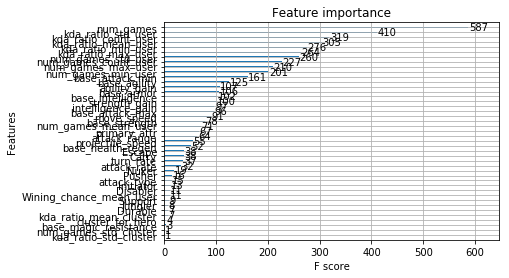

Score:396130.19555362384


In [160]:
dev_X, val_X, dev_y, val_y = train_test_split(train_X,train_y,test_size = 0.2, random_state = 2018)
pred_val_y, score, pred_test_y = runXGB(dev_X, dev_y, val_X, val_y, rounds=5000, training= True,variableImportance=True)
print('Score:{}'.format(score))

In [191]:
params = {
            'max_depth':5, 
            'learning_rate':0.1, 
            'n_estimators':100, 
            'silent':True, 
            'objective':'reg:linear', 
            'booster':'gbtree', 
            'n_jobs':1, 
            'nthread':-1, 
            'gamma':0, 
            'min_child_weight':1, 
            'max_delta_step':0, 
            'subsample':0.8, 
            'colsample_bytree':0.8, 
            'colsample_bylevel':1, 
            'reg_alpha':0, 
            'reg_lambda':1, 
            'scale_pos_weight':1, 
            'base_score':0.5, 
            'random_state':2018, 
            'seed':2018, 
            'missing':0
    }

def return_xgb_model():
    xgb_model = xgb.XGBRegressor(max_depth= params['max_depth'],learning_rate = params['learning_rate'],
                                n_estimators = params['n_estimators'],silent =  params['silent'],
                                objective = params['objective'],booster = params['booster'],
                                n_jobs = params['n_jobs'],nthread = params['nthread'],
                                gamma = params['gamma'],min_child_weight = params['min_child_weight'],
                                max_delta_step = params['max_delta_step'],subsample = params['subsample'],
                                colsample_bytree = params['colsample_bytree'],
                                colsample_bylevel = params['colsample_bylevel'],reg_alpha = params['reg_alpha'],
                                reg_lambda = params['reg_lambda'],scale_pos_weight = params['scale_pos_weight'],
                                base_score = params['base_score'],random_state = params['random_state'],
                                seed = params['seed'],missing = params['missing'])
    return xgb_model

In [188]:
params['n_estimators']=102

In [164]:
xgb_rgsr = return_xgb_model()

param_test_max_depth = {
    'max_depth':range(3,8,1),
}
gsearch_max_depth = GridSearchCV(xgb_rgsr, param_grid = param_test_max_depth, scoring='mean_squared_error', n_jobs=4, iid=False, cv=5)
gsearch_max_depth.fit(train_X,train_y)
print(gsearch_max_depth.grid_scores_)
print("Best parameter: {}, score: {}".format(gsearch_max_depth.best_params_['max_depth'], gsearch_max_depth.best_score_))

[mean: -461816.13741, std: 149955.62102, params: {'max_depth': 3}, mean: -456480.43391, std: 154201.18998, params: {'max_depth': 4}, mean: -468528.69259, std: 150749.10108, params: {'max_depth': 5}, mean: -484124.33266, std: 149789.20063, params: {'max_depth': 6}, mean: -496773.81090, std: 143205.46996, params: {'max_depth': 7}]
Best parameter: 4, score: -456480.43391208956


c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_search.py:761: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [189]:
params['max_depth']=gsearch_max_depth.best_params_['max_depth']

In [192]:
model_names = ['XGB']
print("Model building..")
kf = KFold(n_splits=5, shuffle=True, random_state=2018)
cv_scores = []
pred_test_full = 0
pred_val_full = np.zeros(train_X.shape[0])
for model_name in model_names:
    print("Running model: {}".format(model_name))
    for dev_index, val_index in kf.split(train_X):
        print(len(dev_index), len(val_index))
        dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
        dev_y, val_y = train_y[dev_index], train_y[val_index]
        if model_name == "XGB":
            pred_val_y, score, pred_test_y = runXGB(dev_X, dev_y, val_X, val_y, test_X = test_X, params = params, rounds=7000)
        elif model_name == "LGB":
            pred_val_y, score, pred_test_y = runLGB(dev_X, dev_y, val_X, val_y, test_X = test_X, params = params, rounds=7000)
        pred_val_full[val_index] = pred_val_y
        pred_test_full = pred_test_full + pred_test_y
        cv_scores.append(np.sqrt(score))
    print(cv_scores)
    pred_test_full /= 5.
    test['kda_ratio'] = pred_test_full
    print(np.sqrt(metrics.mean_squared_error(train_y, pred_val_full)))

Model building..
Running model: XGB
1675 419
[0]	dev-rmse:3333.66	val-rmse:3358.09
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[20]	dev-rmse:725.62	val-rmse:767.052
[40]	dev-rmse:510.41	val-rmse:643.47
[60]	dev-rmse:458.506	val-rmse:632.273
[80]	dev-rmse:407.365	val-rmse:631.999
[100]	dev-rmse:367.846	val-rmse:632.118
[120]	dev-rmse:337.89	val-rmse:636.634
[140]	dev-rmse:304.542	val-rmse:637.175
[160]	dev-rmse:275.328	val-rmse:637.602
[180]	dev-rmse:250.546	val-rmse:639.4
Stopping. Best iteration:
[88]	dev-rmse:391.252	val-rmse:629.254

1675 419
[0]	dev-rmse:3335.02	val-rmse:3359.86
Multiple eval metrics have been passed: 'val-rmse' will be used for early stopping.

Will train until val-rmse hasn't improved in 100 rounds.
[20]	dev-rmse:706.801	val-rmse:834.256
[40]	dev-rmse:498.509	val-rmse:702.105
[60]	dev-rmse:456.975	val-rmse:691.845
[80]	dev-rmse:408.927	val-rmse:691.984
[100]	dev-rmse

c:\users\sripan\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
